In [2]:
import glob
import pandas as pd
import numpy as np
import torch
import src as ddfa_node
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from ray.train import Result
import os
from tqdm import tqdm
import copy
%matplotlib inline

# files = glob.glob("/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/ray_results/pb2_bio_server/*ba189*/") # Humans
files = glob.glob("/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/models/vdp_lovelace/**/*.csv") # VDP

In [3]:
# data = ddfa_node.load_data_normalize(6, '/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy')
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")
# time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
# k, τ = 5, 19
k, τ = 4, 12
time_delayed_data = ddfa_node.takens_embedding(data, tau=τ, k=k)

In [4]:
class NODE(torch.nn.Module):
    def __init__(self, func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device, init_steps):
        super(NODE, self).__init__()
        self.func = func
        self.rec = rec
        self.dec = dec
        self.latent_dim = latent_dim
        self.odeint = odeint
        self.samp_ts = samp_ts
        self.val_ts = val_ts
        self.device = device
        self.mode = "train"
        self.init_steps = init_steps

    def forward(self, x):
        h = self.rec.initHidden().to(self.device)
        c = self.rec.initHidden().to(self.device)
        hn = h[0, :, :]
        cn = c[0, :, :]
        if self.mode == "train":
            for t in reversed(range(len(self.samp_ts))):
                obs = x[:, t, :]
                out, hn, cn = self.rec.forward(obs, hn, cn)
        else:
            for t in reversed(range(self.init_steps)):
                obs = x[:, t, :]
                out, hn, cn = self.rec.forward(obs, hn, cn)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        if self.mode == "train":
            pred_z = self.odeint(self.func, z0, self.samp_ts).permute(1, 0, 2)
        else:
            pred_z = self.odeint(self.func, z0, self.val_ts).permute(1, 0, 2)
        # forward in time and solve ode for reconstructions

        pred_x = self.dec(pred_z)

        return pred_x, z0, qz0_mean, qz0_logvar


In [5]:
obs_dim = 10
n_hidden = 64
dec_hidden = 32
device = torch.device("cuda")

######### REMOVE EVENTUALLY #############
data_val = torch.from_numpy(time_delayed_data[:,1:1000,:]).float().to(device)
val_len = data_val.shape[1] * 10


skipped = []
losses = []
for idx, file in enumerate(files):
    # restored_result = Result.from_path(file)
    result = pd.read_csv(file)
    losses.append(result[result["epoch"] == 15]["val_mse_loss"].item())

In [6]:
np.sort(losses)[-20:]

array([-0.30601999, -0.28255564, -0.26953635, -0.26849562, -0.26426136,
       -0.26402211, -0.26323065, -0.25882906, -0.25515667, -0.234458  ,
       -0.23202541, -0.2215898 , -0.21039325, -0.20418049, -0.19575141,
       -0.19043523, -0.18799925, -0.18784025, -0.17957214, -0.13461481])

In [7]:
# Select best performing models (Torch models)
n_keep = 20
use_inds = np.argsort(losses)[-n_keep:]
preds = np.zeros((n_keep, time_delayed_data.shape[0], val_len, obs_dim))
for idx, ind in tqdm(enumerate(use_inds)):
    file = files[ind][:-17] + "model_weights.pt"
    latent_dim = 16
    rnn_hidden = 256
    batch_size = 100
    timesteps_per_trial = 500
    dt = 0.01
    ts_num = timesteps_per_trial * dt
    tot_num = timesteps_per_trial
    samp_ts = np.linspace(0, ts_num, num=tot_num)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)
    
    val_ts = np.linspace(0, dt*val_len, num=val_len)
    val_ts = torch.from_numpy(val_ts).float().to(device)
    
    func = ddfa_node.LatentODEfunc(latent_dim, n_hidden).to(device)
    rec = ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, 0.0, batch_size).to(device)
    dec = ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout=0.0).to(device)
    model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device, timesteps_per_trial)
    state_dict = torch.load(file)
    model.load_state_dict(state_dict)
    model.mode = "val"

    with torch.no_grad():
        out = model.forward(data_val)
    preds[idx, :, :, :] = out[0].detach().cpu()

20it [00:52,  2.61s/it]


In [ ]:
# Select best performing models (Ray models)
n_keep = 10
use_inds = np.argsort(losses)[-n_keep:]
preds = np.zeros((n_keep, time_delayed_data.shape[0], val_len, obs_dim))
for idx, ind in tqdm(enumerate(use_inds)):
    # try:
    file = files[ind][:-17] + "model_weights.pt"
    restored_result = Result.from_path(file)
    # batch_size = restored_result.config["batch_size"]
    timesteps_per_trial = restored_result.config["timesteps_per_trial"]
    dt = 0.01
    ts_num = timesteps_per_trial * dt
    tot_num = timesteps_per_trial
    samp_ts = np.linspace(0, ts_num, num=tot_num)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)

    val_ts = np.linspace(0, dt*val_len, num=val_len)
    val_ts = torch.from_numpy(val_ts).float().to(device)

    batch_size = data_val.shape[0]

    checkpoint = restored_result.get_best_checkpoint(metric="val_mse_loss", mode="max")
    with checkpoint.as_directory() as checkpoint_dir:
        checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        state_dict = checkpoint_dict["model_state_dict"]
        # latent_dim = restored_result.config["latent_dim"]
        # rnn_hidden = restored_result.config["rnn_hidden"]
        # dec_dropout = restored_result.config["dec_dropout"]
        latent_dim = state_dict["func.fc1.weight"].shape[1]
        rnn_hidden = state_dict["rec.lstm.weight_ih"].shape[0] // 4
        func = ddfa_node.LatentODEfunc(latent_dim, n_hidden).to(device)
        rec = ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, 0.0, batch_size).to(device)
        dec = ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout=0.0).to(device)
        model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device, timesteps_per_trial)

        # Load model state and iteration step from checkpoint.
        state_dict = checkpoint_dict["model_state_dict"]
        model.load_state_dict(state_dict)
        model.mode = "val"

    with torch.no_grad():
        out = model.forward(data_val)
    preds[idx, :, :, :] = out[0].detach().cpu()
    # except RuntimeError:
    #     skipped.append(idx)
    #     continue

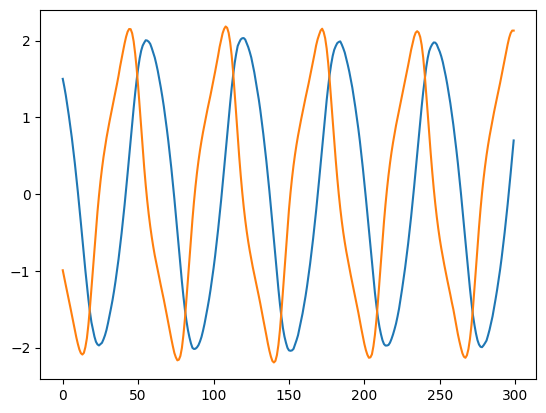

In [8]:
plt.plot(time_delayed_data[0, :300, ::5])

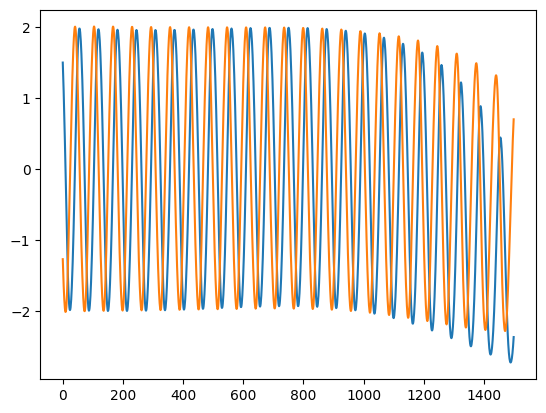

In [12]:
plt.plot(preds[-3, 0, :1500, ::5])

In [13]:
np.save("data/VDP_gen_data_ensemble.npy", preds)

In [ ]:
for idx in range(preds.shape[0]):
    plt.plot(preds[idx, 15, :, ::12])
    plt.figure()

In [1]:
preds.shape

NameError: name 'preds' is not defined

In [11]:
import argparse
import os

import matplotlib
import numpy as np
import numpy.random as npr

matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf

# tf.enable_eager_execution()
tf.keras.backend.set_floatx('float64')

# parser = argparse.ArgumentParser()
# parser.add_argument('--adjoint', type=eval, default=False)
# parser.add_argument('--visualize', type=eval, default=True)
# parser.add_argument('--niters', type=int, default=2000)
# parser.add_argument('--lr', type=float, default=0.01)
# parser.add_argument('--gpu', type=int, default=0)
# parser.add_argument('--train_dir', type=str, default='latent')
# args = parser.parse_args()
train_dir = 'latent'
adjoint = True
visualize = True
niters = 2000
lr = 0.01


from tfdiffeq import odeint, move_to_device

In [3]:
def generate_spiral2d(nspiral=1000,
                      ntotal=500,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.

    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check

    Returns:
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./ground_truth.png', dpi=500)
        print('Saved ground truth spiral at {}'.format('./ground_truth.png'))

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

In [6]:
class LatentODEfunc(tf.keras.Model):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.fc1 = tf.keras.layers.Dense(nhidden, activation='elu')
        self.fc2 = tf.keras.layers.Dense(nhidden, activation='elu')
        self.fc3 = tf.keras.layers.Dense(latent_dim)
        self.nfe = 0

    def call(self, t, x):
        self.nfe += 1

        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(tf.keras.Model):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = tf.keras.layers.Dense(nhidden, activation='tanh')
        self.h2o = tf.keras.layers.Dense(latent_dim * 2)

    def call(self, x, h):
        combined = tf.concat((x, h), axis=1)
        h = self.i2h(combined)
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return tf.zeros([self.nbatch, self.nhidden], dtype=tf.float64)


class Decoder(tf.keras.Model):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(nhidden, activation='relu')
        self.fc2 = tf.keras.layers.Dense(obs_dim)

    def call(self, z):
        out = self.fc1(z)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = tf.convert_to_tensor(np.array([2. * np.pi]), dtype=tf.float64)
    const = move_to_device(const, device)
    const = tf.compat.v1.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / tf.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = tf.exp(lv1)
    v2 = tf.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl


def save_states(orig_ts, orig_trajs, samp_ts, samp_trajs):
    ots = orig_ts.numpy()
    otjs = orig_trajs.numpy()
    sts = samp_ts.numpy()
    stjs = samp_trajs.numpy()

    orig_ts_path = os.path.join(train_dir, 'orig_ts')
    orig_trajs_path = os.path.join(train_dir, 'orig_trajs')
    samp_ts_path = os.path.join(train_dir, 'samp_ts')
    samp_trajs_path = os.path.join(train_dir, 'samp_trajs')

    np.save(orig_ts_path, ots)
    np.save(orig_trajs_path, otjs)
    np.save(samp_ts_path, sts)
    np.save(samp_trajs_path, stjs)


def restore_states():
    orig_ts_path = os.path.join(train_dir, 'orig_ts.npy')
    orig_trajs_path = os.path.join(train_dir, 'orig_trajs.npy')
    samp_ts_path = os.path.join(train_dir, 'samp_ts.npy')
    samp_trajs_path = os.path.join(train_dir, 'samp_trajs.npy')

    ots = tf.convert_to_tensor(np.load(orig_ts_path), dtype=tf.float64)
    otjs = tf.convert_to_tensor(np.load(orig_trajs_path), dtype=tf.float32)
    sts = tf.convert_to_tensor(np.load(samp_ts_path), dtype=tf.float32)
    stjs = tf.convert_to_tensor(np.load(samp_trajs_path), dtype=tf.float32)

    states = dict(orig_ts=ots, orig_trajs=otjs,
                  samp_ts=sts, samp_trajs=stjs)

    return states

In [8]:
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")
time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
#k, τ = 5, 19
#time_delayed_data = ddfa_node.takens_embedding(data, tau=τ, k=k)


data = ddfa_node.change_trial_length(time_delayed_data, timesteps_per_subsample=timesteps_per_sample, skip=100)

# Train/test splitting
train_size = 0.8
data_train, data_val = ddfa_node.split_data(data, train_size=train_size)
obs_dim = data_train.shape[-1]

# Add noise to data
noise_std = 0.2
data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)

######### REMOVE EVENTUALLY #############
data_val = torch.from_numpy(time_delayed_data[:, 1:1000, :]).float().to(device)
#########################################

train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
# train_loader, val_loader = ray.train.torch.prepare_data_loader(train_loader), ray.train.torch.prepare_data_loader(val_loader)
dt = 0.01
ts_num = timesteps_per_sample * dt
tot_num = data_train.shape[1]

samp_ts = np.linspace(0, ts_num, num=tot_num)
samp_ts = torch.from_numpy(samp_ts).float().to(device)


#dt = np.diff(samp_ts.cpu())[1]
val_ts = np.linspace(0, dt*data_val.shape[1], num=data_val.shape[1])
val_ts = torch.from_numpy(val_ts).float().to(device)

func = ddfa_node.LatentODEfunc(latent_dim, n_hidden).to(device)
rec = ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, dec_dropout, batch_size).to(device)
dec = ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout=dec_dropout).to(device)


model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device)

12
Data has been embedded using a delay of 12 timesteps and an embedding dimension of 4


NameError: name 'timesteps_per_sample' is not defined